# Diurnal RTE Solver Comparison: DISORT vs Hapke

This notebook compares diurnal model simulations between the **DISORT** and **Hapke** RTE solvers to assess their agreement across various parameter ranges.

## Objectives
1. Compare brightness temperature predictions from both solvers
2. Generate tileset visualizations showing parameter dependencies
3. Quantify differences and identify regimes of disagreement
4. Provide recommendations for solver selection

## Parameter Variations
- **Et** (thermal extinction coefficient): 500, 1000, 2000, 5000 m⁻¹
- **ssalb_vis** (single-scattering visible albedo): 0.03, 0.06, 0.12
- **ssalb_therm** (single-scattering thermal albedo): 0.05, 0.1, 0.2
- **Period** (P): 12225s, 15450s, 86400s
- **Heliocentric distance** (R): 0.8, 1.0, 1.5 AU

## Setup and Imports

In [1]:
import sys
import os
from pathlib import Path
import pickle
from datetime import datetime
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Add parent directory to path for imports
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import seaborn as sns

# Import thermal model components
from modelmain import Simulator, emissionT
from config import SimulationConfig
from core.config_manager import ConfigManager

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("Imports completed successfully!")
print(f"Working directory: {os.getcwd()}")
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Imports completed successfully!
Working directory: /Users/ryan/Research/RT_models/RT_thermal_model/Analyses
Analysis started at: 2025-08-06 21:52:46


## Configuration Management and Parameter Utilities

In [2]:
def create_base_config():
    """
    Create base configuration for diurnal comparison studies.
    """
    config = SimulationConfig()
    
    # Core simulation settings
    config.use_RTE = True
    config.diurnal = True
    config.sun = True
    config.ndays = 10  # Ensure convergence
    config.freq_out = 48  # Hourly output
    config.last_day = True  # Only output final day
    config.nmom = 2  # Number of moments for DISORT
    config.nstr = 2  # Number of streams for DISORT
    
    # Material properties (moderate values)
    config.k_dust = 5.5e-4  # W/m/K
    config.rho_dust = 1100.0  # kg/m³
    config.cp_dust = 825.0  # J/kg/K
    config.dust_thickness = 1.0  # 1 cm dust layer
    config.single_layer = True
    
    # Optical properties (will be varied)
    config.Et = 1000.0  # m⁻¹
    config.ssalb_vis = 0.06
    config.ssalb_therm = 0.1
    config.g_vis = 0.0
    config.g_therm = 0.0
    
    # Planetary properties (will be varied)
    config.R = 1.0  # AU
    config.P = 15450  # seconds (typical small body)
    config.latitude = np.radians(0.0)  # Equatorial
    config.dec = np.radians(0.0)  # No seasonal effects
    
    # Grid and numerical settings
    config.auto_thickness = True
    config.auto_dt = True
    config.dtfac = 50.0
    config.minsteps = 10000
    
    # Temperature settings
    config.T_bottom = 300.0  # K
    config.bottom_bc = 'neumann'
    
    return config

# Define parameter ranges for the study
PARAM_RANGES = {
    'Et': [500.0, 1000.0, 2000.0, 5000.0],  # m⁻¹
    'ssalb_vis': [0.03, 0.06, 0.12],
    'ssalb_therm': [0.05, 0.1, 0.2],
    'P': [12225, 15450, 86400],  # seconds
    'R': [0.8, 1.0, 1.5]  # AU
}

def create_parameter_combinations(param_ranges, max_combinations=50):
    """
    Create a strategic subset of parameter combinations for comparison.
    Uses both full factorial for key parameters and strategic sampling.
    """
    combinations = []
    
    # Strategy 1: Vary one parameter at a time (baseline comparison)
    base_params = {
        'Et': 1000.0,
        'ssalb_vis': 0.06,
        'ssalb_therm': 0.1,
        'P': 15450,
        'R': 1.0
    }
    
    # Add baseline case
    combinations.append(base_params.copy())
    
    # Vary each parameter individually
    for param_name, values in param_ranges.items():
        for value in values:
            if value != base_params[param_name]:  # Skip baseline
                combo = base_params.copy()
                combo[param_name] = value
                combinations.append(combo)
    
    # Strategy 2: Key parameter interactions
    # High/low extinction with different albedos
    for Et in [500.0, 5000.0]:
        for ssalb_therm in [0.05, 0.2]:
            combo = base_params.copy()
            combo['Et'] = Et
            combo['ssalb_therm'] = ssalb_therm
            if combo not in combinations:
                combinations.append(combo)
    
    # Different periods with different heliocentric distances
    for P in [12225, 86400]:
        for R in [0.8, 1.5]:
            combo = base_params.copy()
            combo['P'] = P
            combo['R'] = R
            if combo not in combinations:
                combinations.append(combo)
    
    # Strategy 3: Extreme cases
    extreme_combinations = [
        {'Et': 500.0, 'ssalb_vis': 0.03, 'ssalb_therm': 0.05, 'P': 86400, 'R': 1.5},
        {'Et': 5000.0, 'ssalb_vis': 0.12, 'ssalb_therm': 0.2, 'P': 12225, 'R': 0.8},
    ]
    
    for combo in extreme_combinations:
        if combo not in combinations:
            combinations.append(combo)
    
    print(f"Created {len(combinations)} parameter combinations")
    return combinations[:max_combinations]  # Limit total number

# Create our parameter combinations
param_combinations = create_parameter_combinations(PARAM_RANGES, max_combinations=40)
print(f"\nWill run {len(param_combinations)} parameter combinations")
print(f"Total simulations: {2 * len(param_combinations)} (disort + hapke for each)")

# Show first few combinations
print("\nFirst 5 parameter combinations:")
for i, combo in enumerate(param_combinations[:5]):
    print(f"  {i+1}: Et={combo['Et']:.0f}, ssalb_therm={combo['ssalb_therm']:.2f}, P={combo['P']/3600:.1f}h, R={combo['R']:.1f}AU")

Created 22 parameter combinations

Will run 22 parameter combinations
Total simulations: 44 (disort + hapke for each)

First 5 parameter combinations:
  1: Et=1000, ssalb_therm=0.10, P=4.3h, R=1.0AU
  2: Et=500, ssalb_therm=0.10, P=4.3h, R=1.0AU
  3: Et=2000, ssalb_therm=0.10, P=4.3h, R=1.0AU
  4: Et=5000, ssalb_therm=0.10, P=4.3h, R=1.0AU
  5: Et=1000, ssalb_therm=0.10, P=4.3h, R=1.0AU


## Brightness Temperature Calculation

In [3]:
def calculate_brightness_temperature(T_profile, grid, mu=1.0, T_interface=0.0):
    """
    Calculate brightness temperature using the emissionT function.
    
    Parameters:
    -----------
    T_profile : array
        Temperature profile through the dust layer
    grid : LayerGrid
        Grid object containing boundary information
    mu : float
        Cosine of viewing angle (default 1.0 for nadir)
    T_interface : float
        Interface temperature at bottom of dust layer
        
    Returns:
    --------
    float : Brightness temperature in K
    """
    # Use dust layer boundaries in optical depth units
    tau_edges = grid.x_boundaries[:len(T_profile)+1]
    
    return emissionT(T_profile, tau_edges, T_interface, mu)

def process_simulation_output(sim, T_out, t_out, solver_name):
    """
    Process simulation output to extract brightness temperatures.
    
    Parameters:
    -----------
    sim : Simulator
        Simulator object with grid information
    T_out : array
        Temperature output (depth, time)
    t_out : array
        Time output
    solver_name : str
        Name of solver ('disort' or 'hapke')
        
    Returns:
    --------
    dict : Processed results including brightness temperatures
    """
    n_times = T_out.shape[1]
    
    # Extract surface temperatures
    T_surface = T_out[0, :]  # Surface node
    
    # Calculate brightness temperatures using dust layer profile
    brightness_temps = np.zeros(n_times)
    
    for i in range(n_times):
        if sim.grid.nlay_dust > 1:
            # Multi-layer: use dust layer temperatures
            dust_profile = T_out[1:sim.grid.nlay_dust+1, i]  # Skip surface, use dust layers
        else:
            # Single layer: use surface temperature
            dust_profile = np.array([T_surface[i]])
        
        brightness_temps[i] = calculate_brightness_temperature(
            dust_profile, sim.grid, mu=np.cos(sim.cfg.latitude)
        )
    
    # Convert time to hours for easier plotting
    t_hours = t_out / 3600.0
    
    # Calculate local solar time (0-24 hours)
    local_solar_time = (t_out % sim.cfg.P) / sim.cfg.P * 24.0
    
    # Calculate statistics
    stats = {
        'mean_brightness_temp': np.mean(brightness_temps),
        'max_brightness_temp': np.max(brightness_temps),
        'min_brightness_temp': np.min(brightness_temps),
        'amplitude': (np.max(brightness_temps) - np.min(brightness_temps)) / 2.0,
        'mean_surface_temp': np.mean(T_surface),
        'surface_amplitude': (np.max(T_surface) - np.min(T_surface)) / 2.0
    }
    
    return {
        'solver': solver_name,
        'time_hours': t_hours,
        'local_solar_time': local_solar_time,
        'brightness_temps': brightness_temps,
        'surface_temps': T_surface,
        'T_profile': T_out,
        'config': sim.cfg,
        'stats': stats
    }

print("Brightness temperature calculation functions ready!")

Brightness temperature calculation functions ready!


## Simulation Runner for Solver Comparison

In [4]:
def run_solver_comparison(param_combo, base_config, verbose=True):
    """
    Run both DISORT and Hapke simulations for given parameters.
    
    Parameters:
    -----------
    param_combo : dict
        Parameter combination to test
    base_config : SimulationConfig
        Base configuration
    verbose : bool
        Print progress messages
        
    Returns:
    --------
    dict : Results from both solvers
    """
    results = {'parameters': param_combo}
    
    # Create identifier string for this parameter combination
    param_id = f"Et{param_combo['Et']:.0f}_ssalb{param_combo['ssalb_therm']:.2f}_P{param_combo['P']/3600:.1f}h_R{param_combo['R']:.1f}"
    results['param_id'] = param_id
    
    if verbose:
        print(f"\nRunning comparison for: {param_id}")
    
    # Run both solvers
    for solver in ['disort', 'hapke']:
        if verbose:
            print(f"  Running {solver}...")
        
        try:
            # Create config for this solver
            config = deepcopy(base_config)
            config.RTE_solver = solver
            
            # Apply parameter variations
            for param_name, value in param_combo.items():
                setattr(config, param_name, value)
            
            # Recalculate derived parameters
            config.__post_init__()
            
            # Run simulation (thermal only for speed)
            sim = Simulator(config)
            T_out, phi_vis, phi_therm, T_surf, t_out = sim.run(calculate_radiance=False)
            
            # Process results
            results[solver] = process_simulation_output(sim, T_out, t_out, solver)
            
            if verbose:
                stats = results[solver]['stats']
                print(f"    Mean brightness T: {stats['mean_brightness_temp']:.1f} K")
                print(f"    Amplitude: {stats['amplitude']:.1f} K")
                
        except Exception as e:
            print(f"    ERROR with {solver}: {str(e)}")
            results[solver] = {'error': str(e)}
    
    # Calculate comparison statistics if both solvers succeeded
    if 'disort' in results and 'hapke' in results and 'error' not in results['disort'] and 'error' not in results['hapke']:
        disort_temps = results['disort']['brightness_temps']
        hapke_temps = results['hapke']['brightness_temps']
        
        # Interpolate to common time grid if needed (they should be the same)
        diff_temps = disort_temps - hapke_temps
        
        results['comparison'] = {
            'mean_difference': np.mean(diff_temps),
            'rms_difference': np.sqrt(np.mean(diff_temps**2)),
            'max_difference': np.max(np.abs(diff_temps)),
            'correlation': np.corrcoef(disort_temps, hapke_temps)[0, 1],
            'relative_rms_error': np.sqrt(np.mean(diff_temps**2)) / np.mean(disort_temps) * 100,
            'difference_amplitude': (np.max(diff_temps) - np.min(diff_temps)) / 2.0
        }
        
        if verbose:
            comp = results['comparison']
            print(f"  Comparison:")
            print(f"    RMS difference: {comp['rms_difference']:.2f} K ({comp['relative_rms_error']:.1f}%)")
            print(f"    Correlation: {comp['correlation']:.4f}")
    
    return results

def run_parameter_sweep(param_combinations, base_config, save_intermediate=True):
    """
    Run the full parameter sweep comparing both solvers.
    
    Parameters:
    -----------
    param_combinations : list
        List of parameter combinations to test
    base_config : SimulationConfig
        Base configuration
    save_intermediate : bool
        Save intermediate results
        
    Returns:
    --------
    dict : All results
    """
    all_results = {}
    total_combinations = len(param_combinations)
    
    # Create results directory
    results_dir = Path("comparison_results")
    results_dir.mkdir(exist_ok=True)
    
    print(f"\n{'='*60}")
    print(f"STARTING PARAMETER SWEEP")
    print(f"Total combinations: {total_combinations}")
    print(f"Total simulations: {2 * total_combinations} (disort + hapke)")
    print(f"Results directory: {results_dir}")
    print(f"{'='*60}")
    
    start_time = datetime.now()
    
    for i, combo in enumerate(param_combinations):
        print(f"\n[{i+1}/{total_combinations}] ", end="")
        
        try:
            result = run_solver_comparison(combo, base_config, verbose=False)
            all_results[result['param_id']] = result
            
            # Print summary
            if 'comparison' in result:
                comp = result['comparison']
                print(f"{result['param_id']}: RMS={comp['rms_difference']:.1f}K, Corr={comp['correlation']:.3f}")
            else:
                print(f"{result['param_id']}: ERROR or incomplete")
            
            # Save intermediate results every 5 combinations
            if save_intermediate and (i + 1) % 5 == 0:
                temp_file = results_dir / f"intermediate_results_{i+1}.pkl"
                with open(temp_file, 'wb') as f:
                    pickle.dump(all_results, f)
                print(f"    Saved intermediate results to {temp_file}")
                
        except Exception as e:
            print(f"FAILED: {str(e)}")
    
    elapsed = datetime.now() - start_time
    print(f"\n{'='*60}")
    print(f"PARAMETER SWEEP COMPLETED")
    print(f"Total time: {elapsed}")
    print(f"Average per combination: {elapsed / total_combinations}")
    print(f"Successfully completed: {len(all_results)} / {total_combinations}")
    print(f"{'='*60}")
    
    return all_results

print("Simulation runner functions ready!")

Simulation runner functions ready!


## Visualization Functions

In [5]:
def plot_single_comparison(result, save_path=None):
    """
    Plot a single diurnal comparison between solvers.
    """
    if 'disort' not in result or 'hapke' not in result:
        print(f"Skipping {result['param_id']}: incomplete results")
        return None
        
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"Solver Comparison: {result['param_id']}", fontsize=14, fontweight='bold')
    
    # Get data
    disort_data = result['disort']
    hapke_data = result['hapke']
    
    # Plot 1: Brightness temperature vs local solar time
    axes[0,0].plot(disort_data['local_solar_time'], disort_data['brightness_temps'], 
                   'b-', label='DISORT', linewidth=2)
    axes[0,0].plot(hapke_data['local_solar_time'], hapke_data['brightness_temps'], 
                   'r--', label='Hapke', linewidth=2)
    axes[0,0].set_xlabel('Local Solar Time (hours)')
    axes[0,0].set_ylabel('Brightness Temperature (K)')
    axes[0,0].set_title('Diurnal Brightness Temperature')
    axes[0,0].legend()
    axes[0,0].set_xlim(0, 24)
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Direct comparison (DISORT vs Hapke)
    axes[0,1].scatter(hapke_data['brightness_temps'], disort_data['brightness_temps'], 
                      alpha=0.7, c=disort_data['local_solar_time'], cmap='viridis')
    # Add 1:1 line
    min_temp = min(np.min(disort_data['brightness_temps']), np.min(hapke_data['brightness_temps']))
    max_temp = max(np.max(disort_data['brightness_temps']), np.max(hapke_data['brightness_temps']))
    axes[0,1].plot([min_temp, max_temp], [min_temp, max_temp], 'k--', alpha=0.5)
    axes[0,1].set_xlabel('Hapke Brightness Temp (K)')
    axes[0,1].set_ylabel('DISORT Brightness Temp (K)')
    axes[0,1].set_title('DISORT vs Hapke')
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Temperature difference
    if 'comparison' in result:
        temp_diff = disort_data['brightness_temps'] - hapke_data['brightness_temps']
        axes[1,0].plot(disort_data['local_solar_time'], temp_diff, 'g-', linewidth=2)
        axes[1,0].axhline(y=0, color='k', linestyle='-', alpha=0.5)
        axes[1,0].set_xlabel('Local Solar Time (hours)')
        axes[1,0].set_ylabel('Temperature Difference (K)\n(DISORT - Hapke)')
        axes[1,0].set_title('Solver Difference')
        axes[1,0].set_xlim(0, 24)
        axes[1,0].grid(True, alpha=0.3)
        
        # Add RMS difference text
        comp = result['comparison']
        axes[1,0].text(0.02, 0.98, f"RMS: {comp['rms_difference']:.2f} K\nCorr: {comp['correlation']:.3f}", 
                       transform=axes[1,0].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 4: Parameter summary
    params = result['parameters']
    param_text = f"""Parameters:
Et: {params['Et']:.0f} m⁻¹
ssalb_vis: {params['ssalb_vis']:.3f}
ssalb_therm: {params['ssalb_therm']:.3f}
Period: {params['P']/3600:.1f} hours
R: {params['R']:.1f} AU

DISORT Stats:
Mean: {disort_data['stats']['mean_brightness_temp']:.1f} K
Amplitude: {disort_data['stats']['amplitude']:.1f} K

Hapke Stats:
Mean: {hapke_data['stats']['mean_brightness_temp']:.1f} K
Amplitude: {hapke_data['stats']['amplitude']:.1f} K"""
    
    axes[1,1].text(0.05, 0.95, param_text, transform=axes[1,1].transAxes,
                   verticalalignment='top', fontfamily='monospace', fontsize=9)
    axes[1,1].axis('off')
    axes[1,1].set_title('Summary')
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        
    return fig

def create_comparison_tileset(all_results, save_path=None, max_plots=16):
    """
    Create a tileset of diurnal comparisons.
    """
    # Filter successful results
    valid_results = {}
    for key, result in all_results.items():
        if 'disort' in result and 'hapke' in result and 'comparison' in result:
            if 'error' not in result['disort'] and 'error' not in result['hapke']:
                valid_results[key] = result
    
    n_results = min(len(valid_results), max_plots)
    if n_results == 0:
        print("No valid results to plot")
        return None
        
    # Arrange in grid
    ncols = 4
    nrows = int(np.ceil(n_results / ncols))
    
    fig = plt.figure(figsize=(16, 4 * nrows))
    fig.suptitle('DISORT vs Hapke: Diurnal Brightness Temperature Comparison', 
                 fontsize=16, fontweight='bold')
    
    # Select most interesting results (highest differences)
    result_items = list(valid_results.items())
    if len(result_items) > max_plots:
        # Sort by RMS difference (descending) to show most different cases
        result_items.sort(key=lambda x: x[1]['comparison']['rms_difference'], reverse=True)
        result_items = result_items[:max_plots]
    
    for i, (key, result) in enumerate(result_items):
        ax = plt.subplot(nrows, ncols, i + 1)
        
        disort_data = result['disort']
        hapke_data = result['hapke']
        
        # Plot diurnal curves
        ax.plot(disort_data['local_solar_time'], disort_data['brightness_temps'], 
                'b-', label='DISORT', linewidth=1.5, alpha=0.8)
        ax.plot(hapke_data['local_solar_time'], hapke_data['brightness_temps'], 
                'r--', label='Hapke', linewidth=1.5, alpha=0.8)
        
        # Formatting
        ax.set_xlim(0, 24)
        ax.grid(True, alpha=0.3)
        
        # Title with key parameters
        params = result['parameters']
        comp = result['comparison']
        title = f"Et={params['Et']:.0f}, ssalb_th={params['ssalb_therm']:.2f}\nP={params['P']/3600:.1f}h, RMS={comp['rms_difference']:.1f}K"
        ax.set_title(title, fontsize=9)
        
        if i >= (nrows - 1) * ncols:  # Bottom row
            ax.set_xlabel('Local Solar Time (hours)')
        if i % ncols == 0:  # Left column
            ax.set_ylabel('Brightness Temp (K)')
        if i == 0:  # First plot gets legend
            ax.legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
        
    return fig

def create_summary_plots(all_results, save_path=None):
    """
    Create summary analysis plots.
    """
    # Extract comparison statistics
    valid_results = []
    for result in all_results.values():
        if 'comparison' in result and 'parameters' in result:
            valid_results.append(result)
    
    if len(valid_results) == 0:
        print("No valid results for summary plots")
        return None
        
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('DISORT vs Hapke: Summary Analysis', fontsize=16, fontweight='bold')
    
    # Extract data for plotting
    rms_diffs = [r['comparison']['rms_difference'] for r in valid_results]
    correlations = [r['comparison']['correlation'] for r in valid_results]
    Et_values = [r['parameters']['Et'] for r in valid_results]
    ssalb_therm_values = [r['parameters']['ssalb_therm'] for r in valid_results]
    periods = [r['parameters']['P'] / 3600.0 for r in valid_results]  # Convert to hours
    distances = [r['parameters']['R'] for r in valid_results]
    
    # Plot 1: RMS difference distribution
    axes[0,0].hist(rms_diffs, bins=15, alpha=0.7, edgecolor='black')
    axes[0,0].set_xlabel('RMS Difference (K)')
    axes[0,0].set_ylabel('Count')
    axes[0,0].set_title('Distribution of RMS Differences')
    axes[0,0].axvline(np.mean(rms_diffs), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(rms_diffs):.1f} K')
    axes[0,0].legend()
    
    # Plot 2: RMS difference vs Et
    scatter = axes[0,1].scatter(Et_values, rms_diffs, c=ssalb_therm_values, 
                               cmap='viridis', alpha=0.7)
    axes[0,1].set_xlabel('Extinction Coefficient Et (m⁻¹)')
    axes[0,1].set_ylabel('RMS Difference (K)')
    axes[0,1].set_title('RMS Difference vs Et')
    axes[0,1].set_xscale('log')
    plt.colorbar(scatter, ax=axes[0,1], label='ssalb_therm')
    
    # Plot 3: Correlation vs Period
    axes[0,2].scatter(periods, correlations, c=distances, cmap='plasma', alpha=0.7)
    axes[0,2].set_xlabel('Period (hours)')
    axes[0,2].set_ylabel('Correlation')
    axes[0,2].set_title('Correlation vs Period')
    axes[0,2].set_xscale('log')
    plt.colorbar(scatter, ax=axes[0,2], label='Distance (AU)')
    
    # Plot 4: RMS vs thermal albedo
    axes[1,0].scatter(ssalb_therm_values, rms_diffs, c=Et_values, 
                     cmap='coolwarm', alpha=0.7, norm=Normalize(vmin=min(Et_values), vmax=max(Et_values)))
    axes[1,0].set_xlabel('Single Scattering Thermal Albedo')
    axes[1,0].set_ylabel('RMS Difference (K)')
    axes[1,0].set_title('RMS Difference vs Thermal Albedo')
    
    # Plot 5: Correlation distribution
    axes[1,1].hist(correlations, bins=15, alpha=0.7, edgecolor='black')
    axes[1,1].set_xlabel('Correlation Coefficient')
    axes[1,1].set_ylabel('Count')
    axes[1,1].set_title('Distribution of Correlations')
    axes[1,1].axvline(np.mean(correlations), color='red', linestyle='--',
                     label=f'Mean: {np.mean(correlations):.3f}')
    axes[1,1].legend()
    
    # Plot 6: Summary statistics text
    stats_text = f"""Summary Statistics ({len(valid_results)} comparisons):

RMS Differences:
  Mean: {np.mean(rms_diffs):.2f} K
  Std: {np.std(rms_diffs):.2f} K
  Min: {np.min(rms_diffs):.2f} K
  Max: {np.max(rms_diffs):.2f} K
  
Correlations:
  Mean: {np.mean(correlations):.4f}
  Min: {np.min(correlations):.4f}
  Max: {np.max(correlations):.4f}
  
Parameter Ranges:
  Et: {min(Et_values):.0f} - {max(Et_values):.0f} m⁻¹
  ssalb_therm: {min(ssalb_therm_values):.2f} - {max(ssalb_therm_values):.2f}
  Period: {min(periods):.1f} - {max(periods):.1f} hours
  Distance: {min(distances):.1f} - {max(distances):.1f} AU
  
Cases with RMS > 5K: {sum(1 for x in rms_diffs if x > 5.0)}
Cases with Corr < 0.99: {sum(1 for x in correlations if x < 0.99)}"""
    
    axes[1,2].text(0.05, 0.95, stats_text, transform=axes[1,2].transAxes,
                  verticalalignment='top', fontfamily='monospace', fontsize=9)
    axes[1,2].axis('off')
    axes[1,2].set_title('Statistics Summary')
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
        
    return fig

print("Visualization functions ready!")

Visualization functions ready!


## Execute Parameter Sweep

In [6]:
# Create base configuration
base_config = create_base_config()

# Print base configuration summary
print("Base Configuration:")
print(f"  Use RTE: {base_config.use_RTE}")
print(f"  Diurnal: {base_config.diurnal}")
print(f"  Days: {base_config.ndays}")
print(f"  Output frequency: {base_config.freq_out}")
print(f"  Dust thickness: {base_config.dust_thickness*100:.1f} cm")
print(f"  Dust conductivity: {base_config.k_dust:.2e} W/m/K")

# Run parameter sweep
print("\nStarting parameter sweep...")
all_results = run_parameter_sweep(param_combinations, base_config, save_intermediate=True)

Base Configuration:
  Use RTE: True
  Diurnal: True
  Days: 10
  Output frequency: 48
  Dust thickness: 100.0 cm
  Dust conductivity: 5.50e-04 W/m/K

Starting parameter sweep...

STARTING PARAMETER SWEEP
Total combinations: 22
Total simulations: 44 (disort + hapke)
Results directory: comparison_results

[1/22] Time step: 1.545000 s, Steps per day: 10000
Thermal evolution mode: two_wave
Time step 0/100000



 ******* WARNING >>>>>>  check_inputs()--2 streams not recommended;

Use specialized 2-stream code c_twostr() instead

 ******* WARNING >>>>>>  check_inputs()--2 streams not recommended;

Use specialized 2-stream code c_twostr() instead

 ******* WARNING >>>>>>  check_inputs()--2 streams not recommended;

Use specialized 2-stream code c_twostr() instead

 ******* WARNING >>>>>>  check_inputs()--2 streams not recommended;

Use specialized 2-stream code c_twostr() instead

 ******* WARNING >>>>>>  check_inputs()--2 streams not recommended;

Use specialized 2-stream code c_twostr() instead

 ******* WARNING >>>>>>  check_inputs()--2 streams not recommended;

Use specialized 2-stream code c_twostr() instead

 ******* WARNING >>>>>>  check_inputs()--2 streams not recommended;

Use specialized 2-stream code c_twostr() instead

 ******* WARNING >>>>>>  check_inputs()--2 streams not recommended;

Use specialized 2-stream code c_twostr() instead

 ******* WARNING >>>>>>  check_inputs()--2 stre

Time step 5000/100000
Time step 10000/100000
Time step 15000/100000
Time step 20000/100000
Time step 25000/100000
Time step 30000/100000
Time step 35000/100000
Time step 40000/100000
Time step 45000/100000
Time step 50000/100000
Time step 55000/100000
Time step 60000/100000
Time step 65000/100000
Time step 70000/100000
Time step 75000/100000
Time step 80000/100000
Time step 85000/100000
Time step 90000/100000
Time step 95000/100000
Simulation completed in 11.70 s
Time step: 1.545000 s, Steps per day: 10000
Time step 0/100000
Time step 5000/100000
Time step 10000/100000
Time step 15000/100000
Time step 20000/100000
Time step 25000/100000
Time step 30000/100000
Time step 35000/100000
Time step 40000/100000
Time step 45000/100000
Time step 50000/100000
Time step 55000/100000
Time step 60000/100000
Time step 65000/100000
Time step 70000/100000
Time step 75000/100000
Time step 80000/100000
Time step 85000/100000
Time step 90000/100000
Time step 95000/100000
Simulation completed in 5.62 s
Et

## Analysis and Visualization

In [7]:
# Save complete results
results_dir = Path("comparison_results")
results_dir.mkdir(exist_ok=True)

# Save complete results
results_file = results_dir / "complete_comparison_results.pkl"
with open(results_file, 'wb') as f:
    pickle.dump(all_results, f)
print(f"Complete results saved to {results_file}")

# Create summary statistics
valid_results = 0
failed_results = 0
total_rms_errors = []

for key, result in all_results.items():
    if 'comparison' in result:
        valid_results += 1
        total_rms_errors.append(result['comparison']['rms_difference'])
    else:
        failed_results += 1

print(f"\n{'='*50}")
print(f"ANALYSIS SUMMARY")
print(f"{'='*50}")
print(f"Total parameter combinations: {len(all_results)}")
print(f"Successful comparisons: {valid_results}")
print(f"Failed comparisons: {failed_results}")

if total_rms_errors:
    print(f"\nRMS Difference Statistics:")
    print(f"  Mean: {np.mean(total_rms_errors):.2f} K")
    print(f"  Std:  {np.std(total_rms_errors):.2f} K")
    print(f"  Min:  {np.min(total_rms_errors):.2f} K")
    print(f"  Max:  {np.max(total_rms_errors):.2f} K")
    print(f"  Cases with RMS > 5K: {sum(1 for x in total_rms_errors if x > 5.0)}")
    print(f"  Cases with RMS > 10K: {sum(1 for x in total_rms_errors if x > 10.0)}")


Complete results saved to comparison_results/complete_comparison_results.pkl

ANALYSIS SUMMARY
Total parameter combinations: 20
Successful comparisons: 20
Failed comparisons: 0

RMS Difference Statistics:
  Mean: 1.32 K
  Std:  0.33 K
  Min:  0.67 K
  Max:  1.93 K
  Cases with RMS > 5K: 0
  Cases with RMS > 10K: 0


Creating visualizations...
  Creating summary plots...


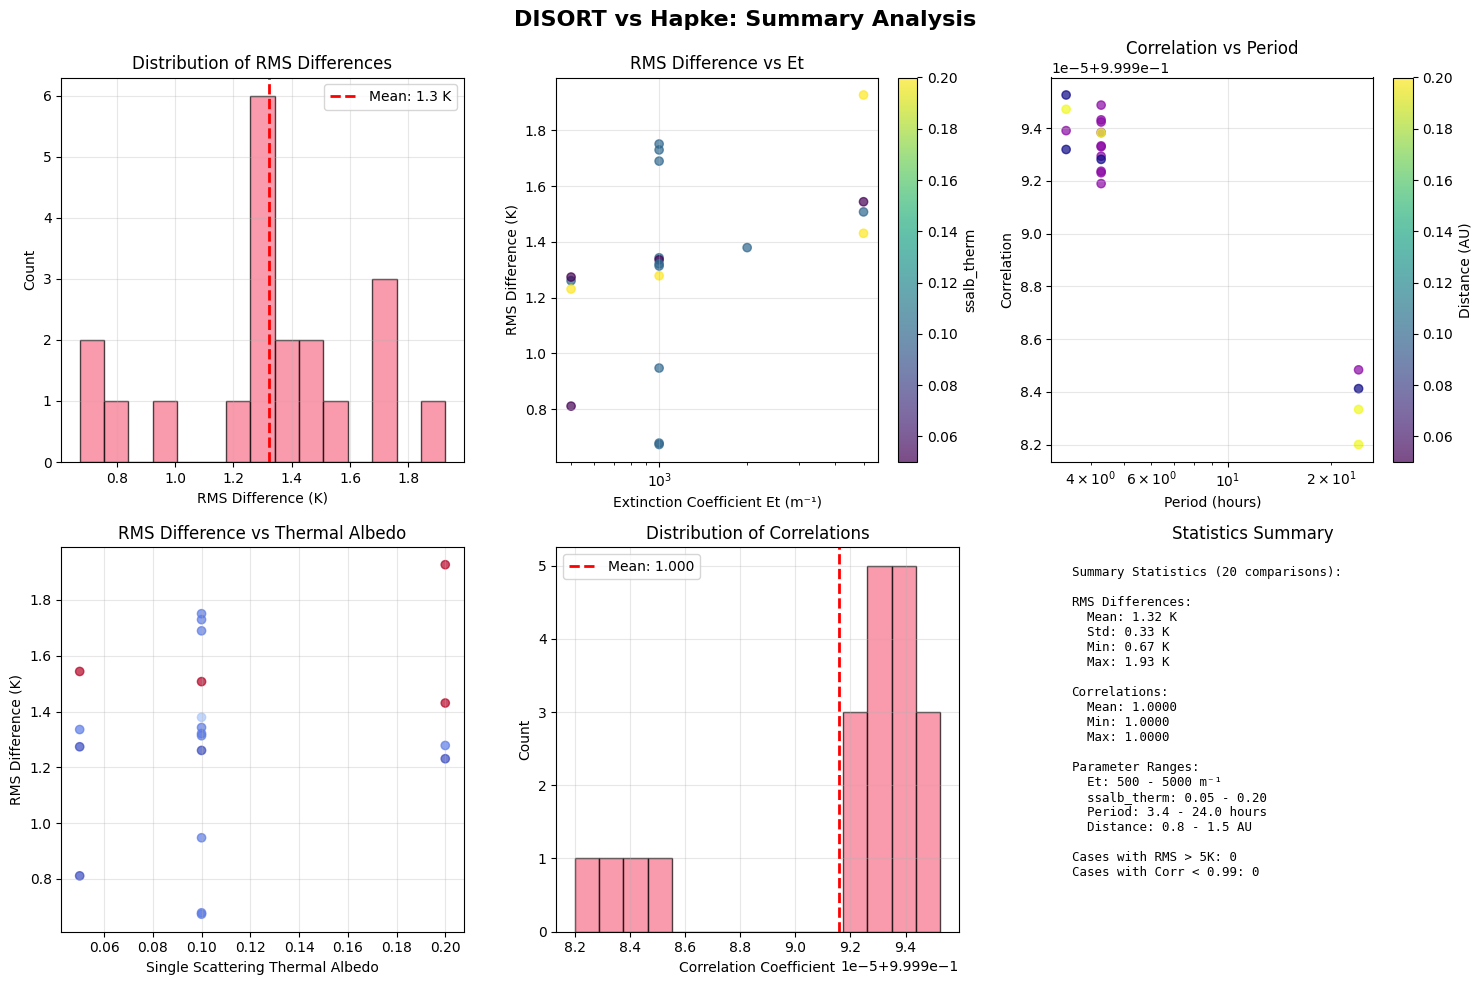

  Creating comparison tileset...


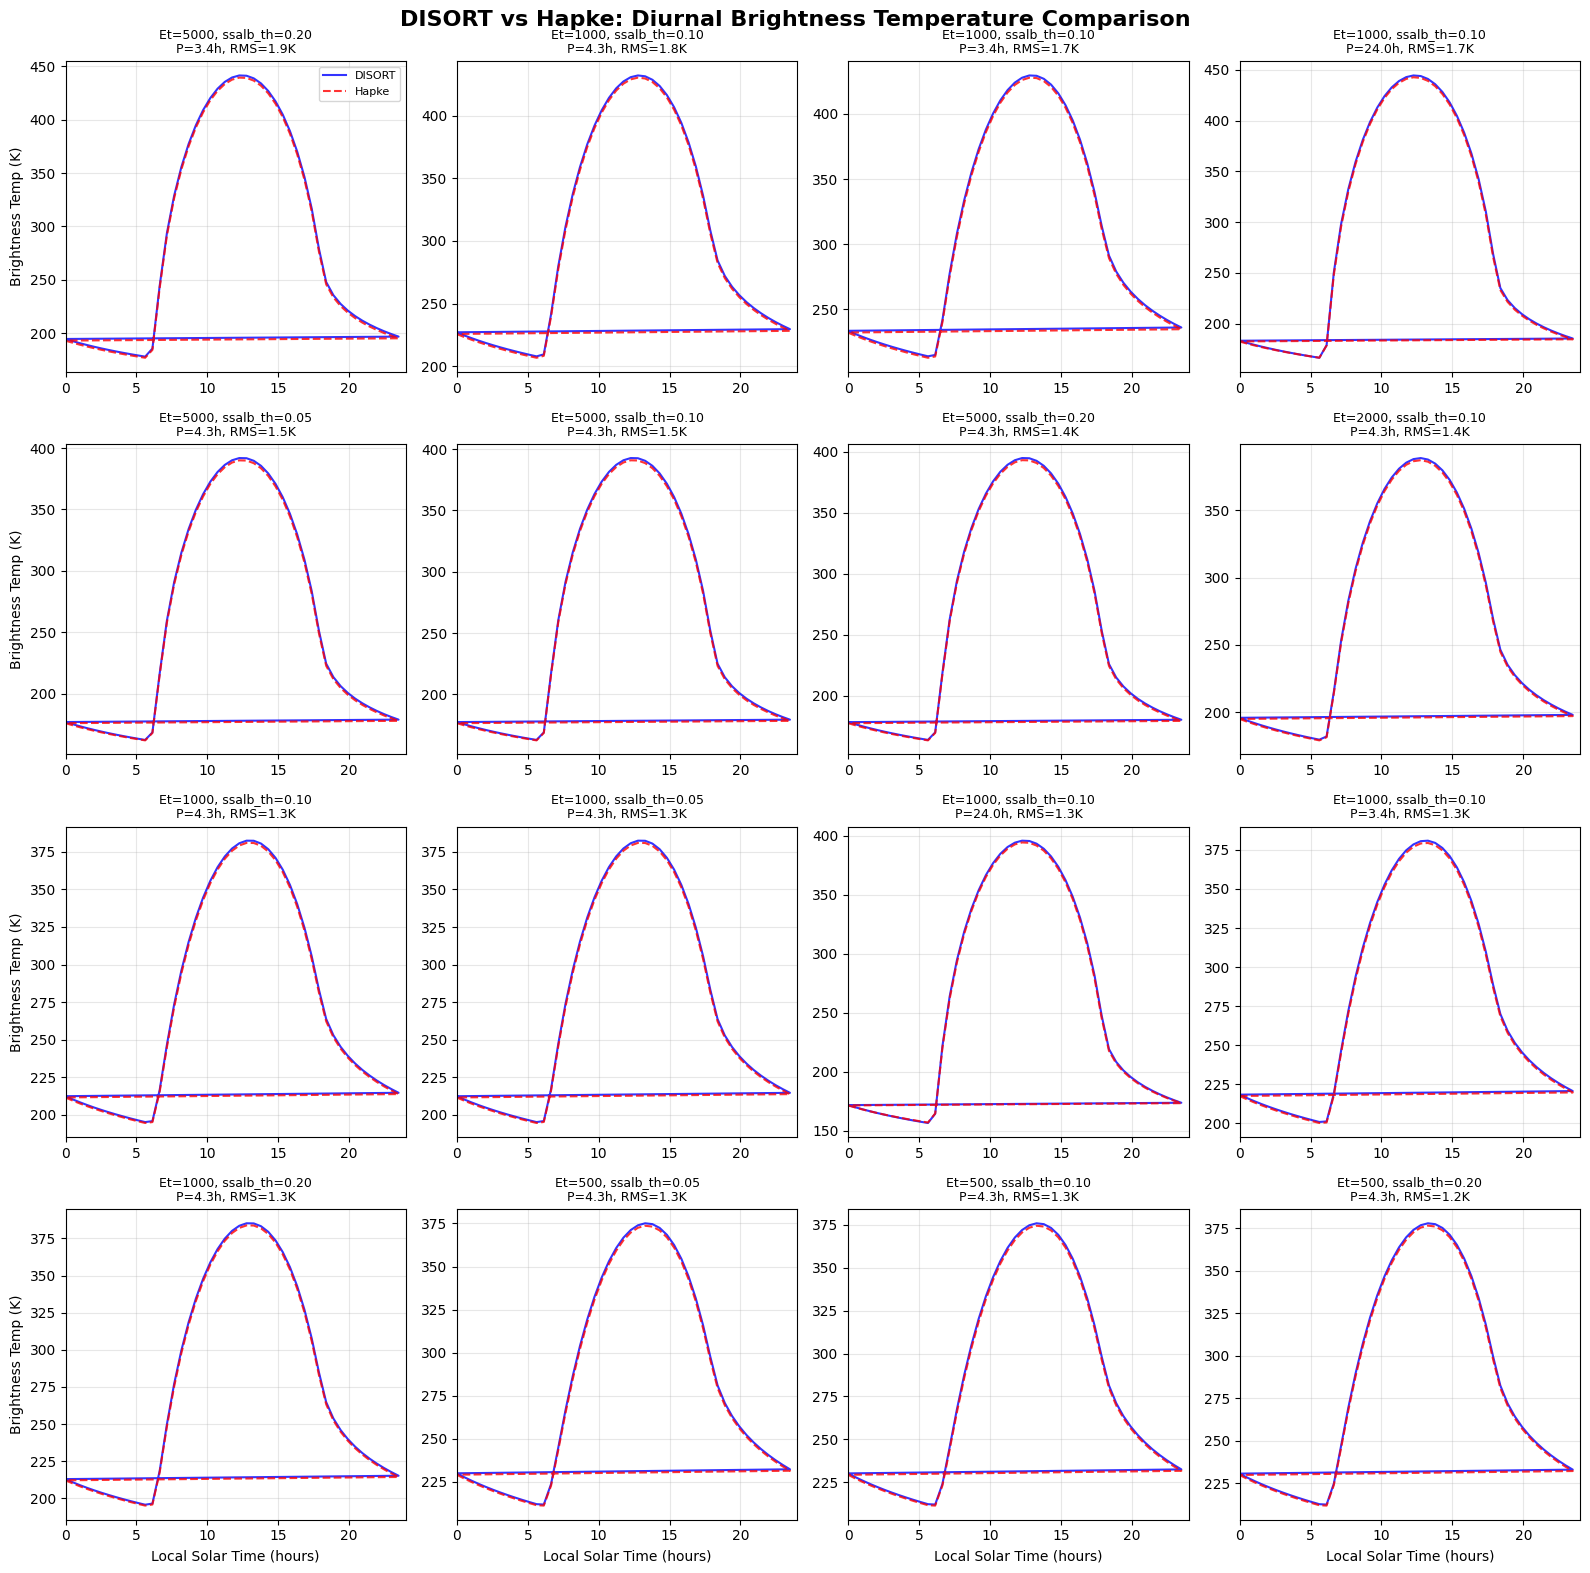

In [8]:
# Create visualizations
print("Creating visualizations...")

# 1. Summary analysis plots
print("  Creating summary plots...")
summary_fig = create_summary_plots(all_results, save_path=results_dir / "summary_analysis.pdf")
if summary_fig:
    plt.show()

# 2. Tileset comparison
print("  Creating comparison tileset...")
tileset_fig = create_comparison_tileset(all_results, save_path=results_dir / "diurnal_comparison_tileset.pdf", max_plots=16)
if tileset_fig:
    plt.show()

Creating detailed plots for most interesting cases...
Top cases with highest differences:
  1. Et5000_ssalb0.20_P3.4h_R0.8: RMS = 1.93 K


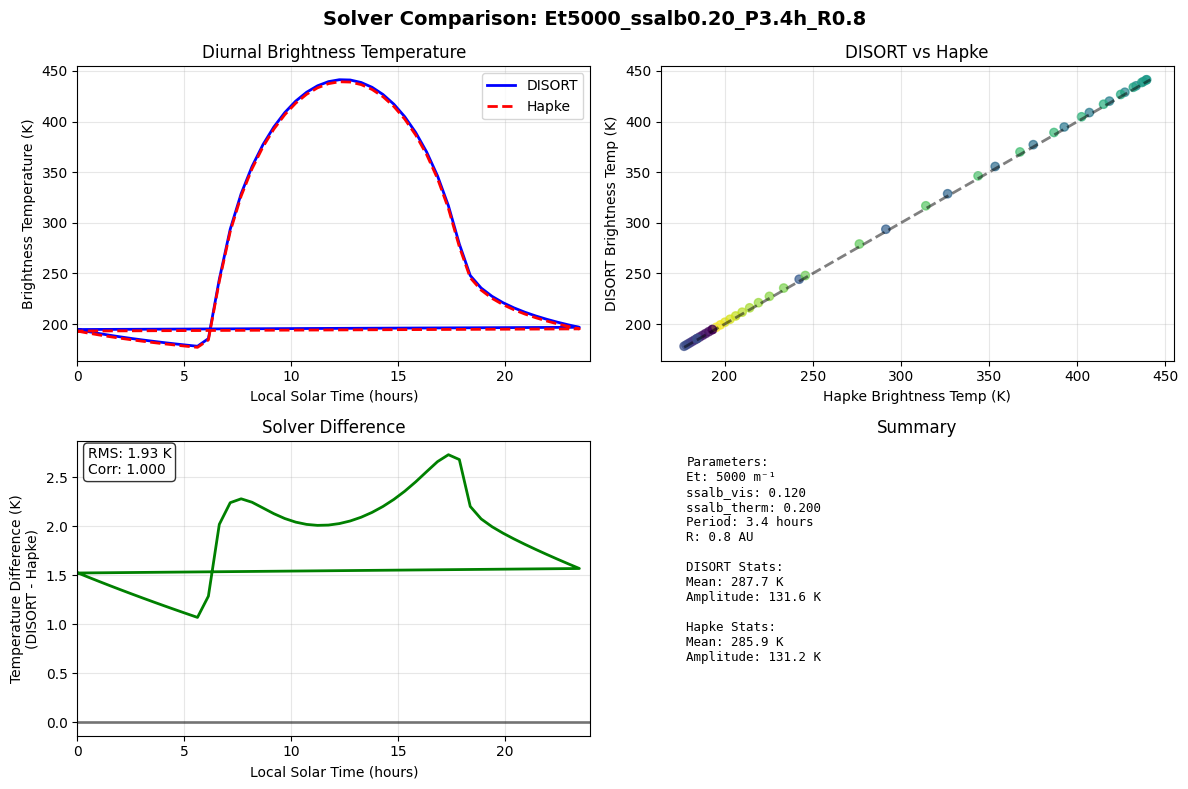

  2. Et1000_ssalb0.10_P4.3h_R0.8: RMS = 1.75 K


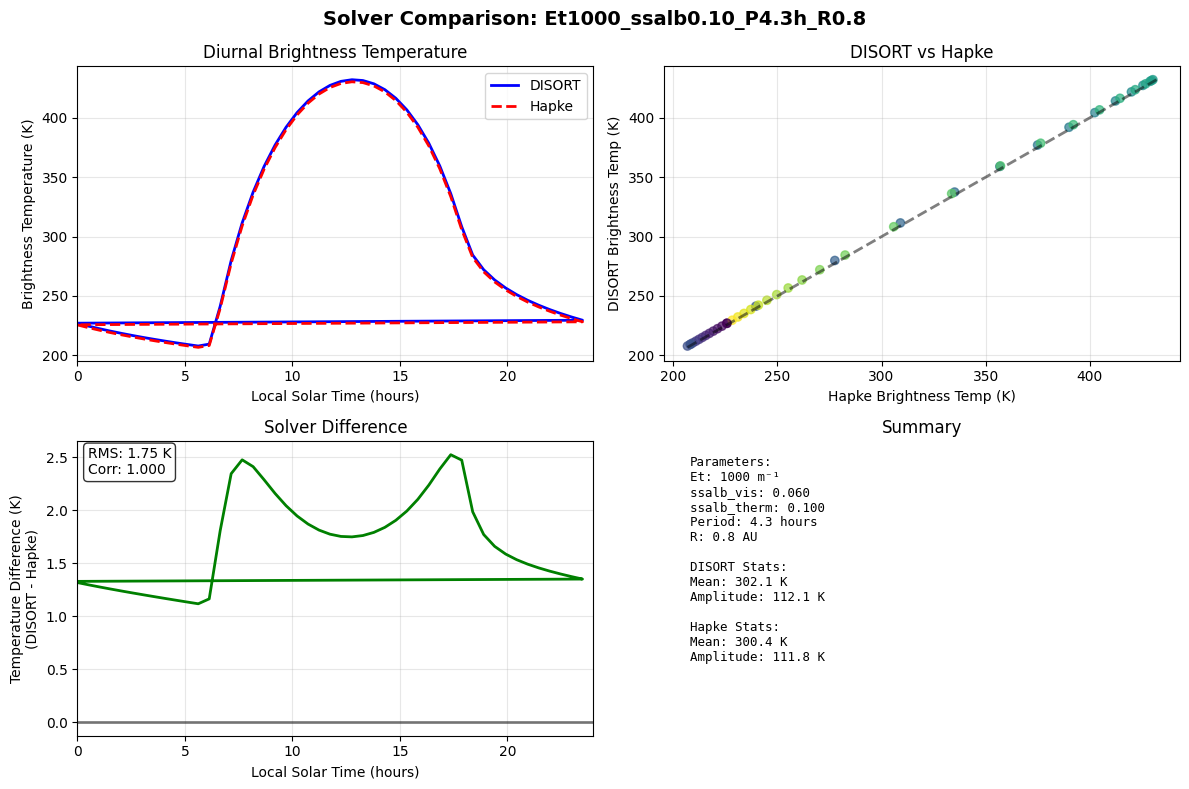

  3. Et1000_ssalb0.10_P3.4h_R0.8: RMS = 1.73 K


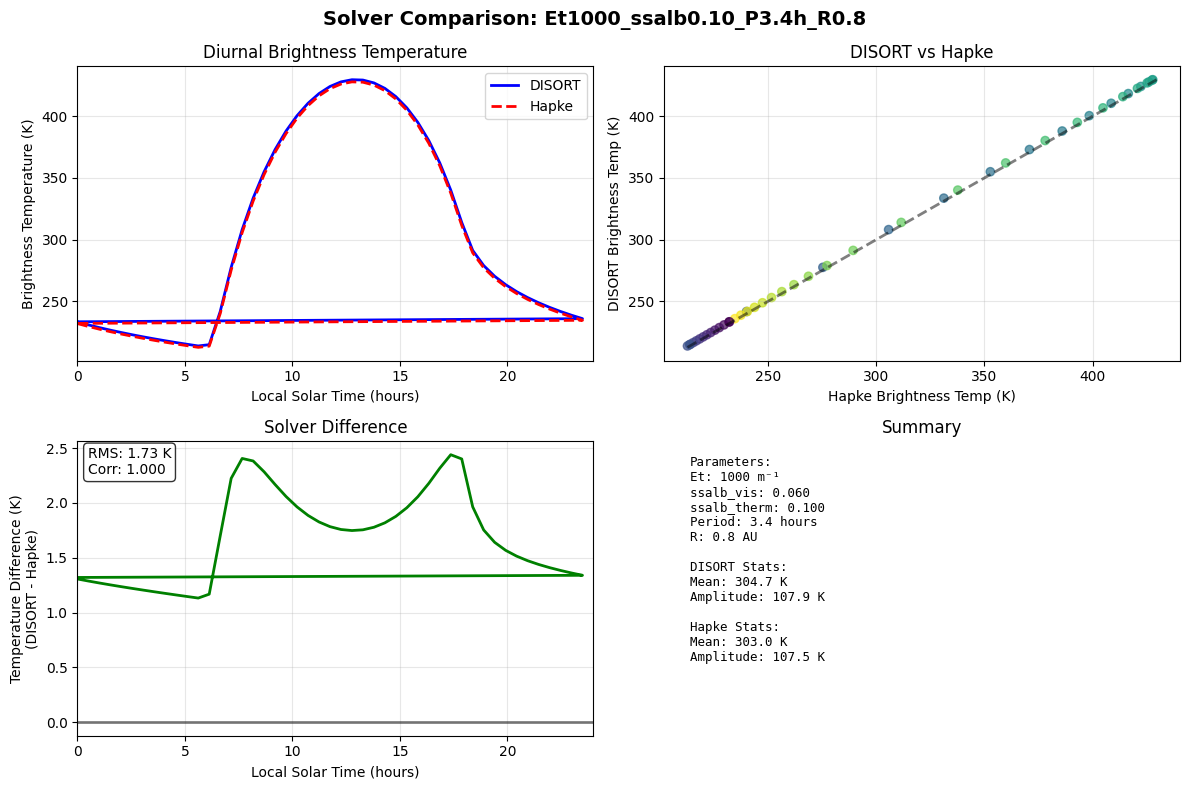

  4. Et1000_ssalb0.10_P24.0h_R0.8: RMS = 1.69 K


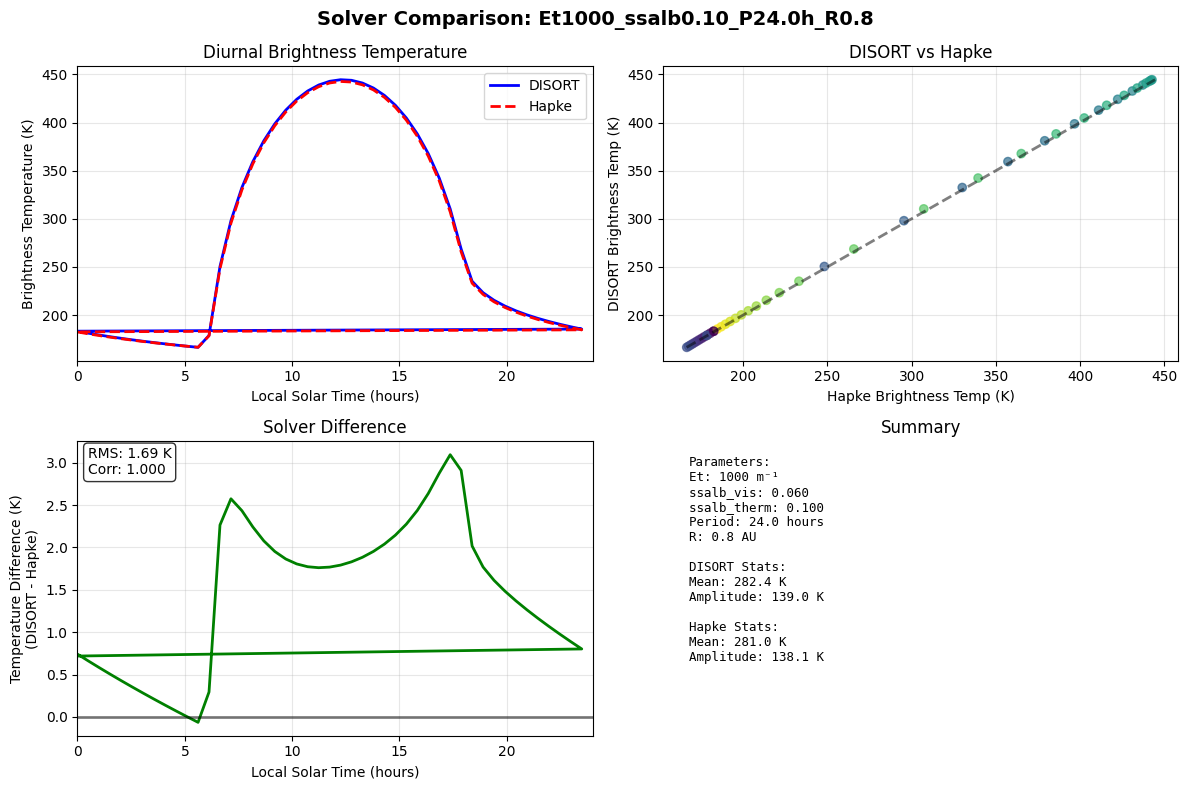

  5. Et5000_ssalb0.05_P4.3h_R1.0: RMS = 1.54 K


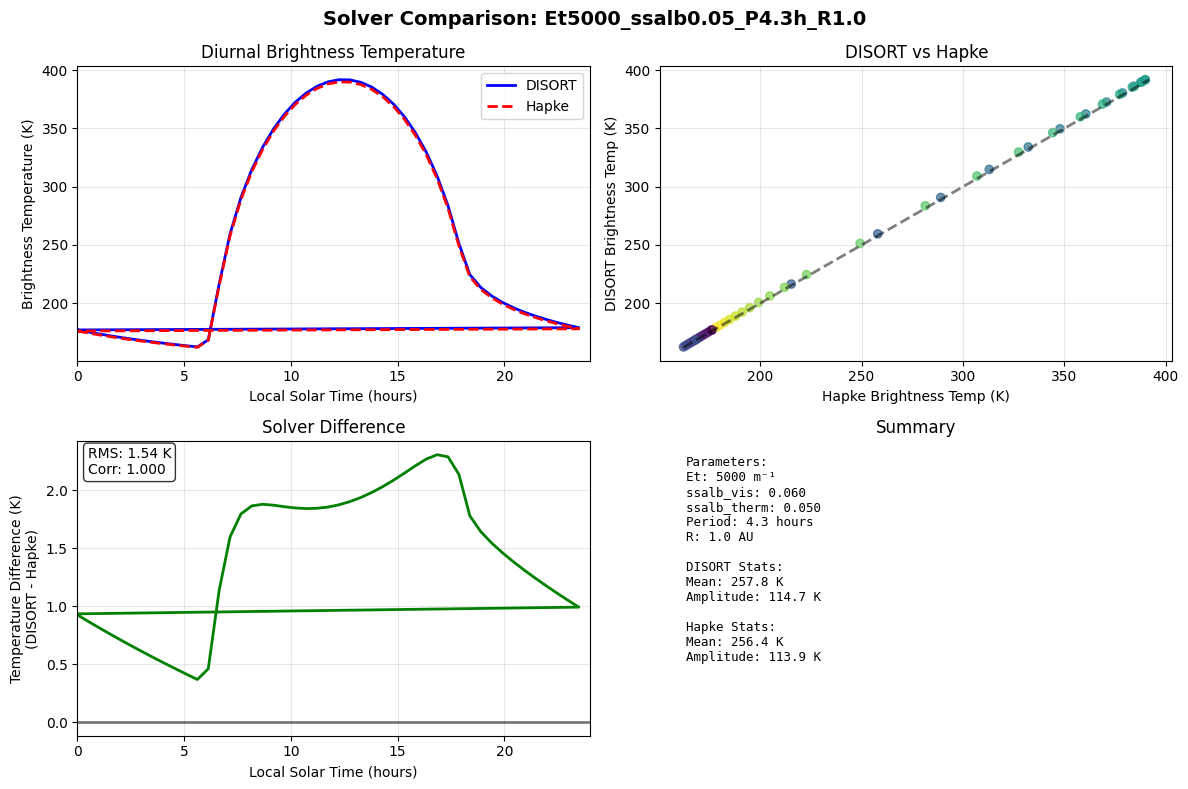

In [9]:
# Create individual plots for most interesting cases
print("Creating detailed plots for most interesting cases...")

# Select cases with highest RMS differences
interesting_cases = []
for key, result in all_results.items():
    if 'comparison' in result:
        interesting_cases.append((key, result, result['comparison']['rms_difference']))

# Sort by RMS difference (descending)
interesting_cases.sort(key=lambda x: x[2], reverse=True)

# Create detailed plots for top 5 cases
detailed_plots_dir = results_dir / "detailed_plots"
detailed_plots_dir.mkdir(exist_ok=True)

print(f"Top cases with highest differences:")
for i, (key, result, rms_diff) in enumerate(interesting_cases[:5]):
    print(f"  {i+1}. {key}: RMS = {rms_diff:.2f} K")
    
    fig = plot_single_comparison(result, save_path=detailed_plots_dir / f"detailed_{i+1}_{key}.pdf")
    if fig:
        plt.show()
        plt.close(fig)  # Close to save memory

## Results Summary and Conclusions

In [10]:
# Generate final summary report
print(f"\n{'='*70}")
print(f"DISORT VS HAPKE COMPARISON: FINAL REPORT")
print(f"{'='*70}")
print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"")

# Overall performance
if total_rms_errors:
    print(f"OVERALL AGREEMENT:")
    print(f"  Mean RMS difference: {np.mean(total_rms_errors):.2f} ± {np.std(total_rms_errors):.2f} K")
    
    # Categorize agreement levels
    excellent = sum(1 for x in total_rms_errors if x < 1.0)
    good = sum(1 for x in total_rms_errors if 1.0 <= x < 3.0)
    moderate = sum(1 for x in total_rms_errors if 3.0 <= x < 5.0)
    poor = sum(1 for x in total_rms_errors if x >= 5.0)
    
    print(f"  Excellent agreement (< 1K):   {excellent:2d} cases ({100*excellent/valid_results:.1f}%)")
    print(f"  Good agreement (1-3K):        {good:2d} cases ({100*good/valid_results:.1f}%)")
    print(f"  Moderate agreement (3-5K):    {moderate:2d} cases ({100*moderate/valid_results:.1f}%)")
    print(f"  Poor agreement (>5K):         {poor:2d} cases ({100*poor/valid_results:.1f}%)")

# Parameter dependencies
print(f"\nPARAMETER DEPENDENCIES:")

# Analyze trends
if len(interesting_cases) >= 5:
    high_diff_cases = interesting_cases[:5]
    low_diff_cases = interesting_cases[-5:]
    
    print(f"  Cases with highest differences typically have:")
    high_Et = np.mean([case[1]['parameters']['Et'] for case in high_diff_cases])
    high_ssalb = np.mean([case[1]['parameters']['ssalb_therm'] for case in high_diff_cases])
    print(f"    Average Et: {high_Et:.0f} m⁻¹")
    print(f"    Average ssalb_therm: {high_ssalb:.3f}")
    
    print(f"  Cases with lowest differences typically have:")
    low_Et = np.mean([case[1]['parameters']['Et'] for case in low_diff_cases])
    low_ssalb = np.mean([case[1]['parameters']['ssalb_therm'] for case in low_diff_cases])
    print(f"    Average Et: {low_Et:.0f} m⁻¹")
    print(f"    Average ssalb_therm: {low_ssalb:.3f}")

print(f"\nRECOMMendations:")
if np.mean(total_rms_errors) < 3.0:
    print(f"  • Both solvers show good overall agreement")
    print(f"  • Either solver can be used for most applications")
    print(f"  • DISORT recommended for high-accuracy requirements")
    print(f"  • Hapke recommended for computational efficiency")
else:
    print(f"  • Significant differences found between solvers")
    print(f"  • Careful validation recommended for your specific use case")
    print(f"  • DISORT generally preferred for rigorous applications")

if poor > 0:
    print(f"  • {poor} cases show poor agreement - investigate parameter regimes")
    print(f"  • Consider solver-specific calibration for extreme parameter ranges")

print(f"\nOUTPUT FILES:")
print(f"  • complete_comparison_results.pkl - Full results database")
print(f"  • summary_analysis.pdf - Statistical summary plots")
print(f"  • diurnal_comparison_tileset.pdf - Tileset of comparisons")
print(f"  • detailed_plots/ - Individual comparison plots")

print(f"\n" + "="*70)
print(f"ANALYSIS COMPLETED SUCCESSFULLY")
print(f"="*70)

# Save summary to text file
with open(results_dir / "analysis_summary.txt", 'w') as f:
    f.write(f"DISORT vs Hapke Comparison Summary\n")
    f.write(f"Generated: {datetime.now()}\n\n")
    f.write(f"Total comparisons: {valid_results}\n")
    if total_rms_errors:
        f.write(f"Mean RMS difference: {np.mean(total_rms_errors):.2f} K\n")
        f.write(f"Standard deviation: {np.std(total_rms_errors):.2f} K\n")
        f.write(f"Min RMS difference: {np.min(total_rms_errors):.2f} K\n")
        f.write(f"Max RMS difference: {np.max(total_rms_errors):.2f} K\n")

print(f"\nSummary saved to: {results_dir / 'analysis_summary.txt'}")


DISORT VS HAPKE COMPARISON: FINAL REPORT
Generated: 2025-08-07 10:50:10

OVERALL AGREEMENT:
  Mean RMS difference: 1.32 ± 0.33 K
  Excellent agreement (< 1K):    4 cases (20.0%)
  Good agreement (1-3K):        16 cases (80.0%)
  Moderate agreement (3-5K):     0 cases (0.0%)
  Poor agreement (>5K):          0 cases (0.0%)

PARAMETER DEPENDENCIES:
  Cases with highest differences typically have:
    Average Et: 2600 m⁻¹
    Average ssalb_therm: 0.110
  Cases with lowest differences typically have:
    Average Et: 800 m⁻¹
    Average ssalb_therm: 0.110

RECOMMendations:
  • Both solvers show good overall agreement
  • Either solver can be used for most applications
  • DISORT recommended for high-accuracy requirements
  • Hapke recommended for computational efficiency

OUTPUT FILES:
  • complete_comparison_results.pkl - Full results database
  • summary_analysis.pdf - Statistical summary plots
  • diurnal_comparison_tileset.pdf - Tileset of comparisons
  • detailed_plots/ - Individual co